# Objectives {.unnumbered}

By the end of this lab, you will:
1. Load and analyze the **Lightcast dataset** in **Spark DataFrame**.
2. Create **five easy and three medium-complexity visualizations** using **Plotly**.
3. Explore **salary distributions, employment trends, and job postings**.
4. Analyze **skills in relation to NAICS/SOC/ONET codes and salaries**.
5. Customize **colors, fonts, and styles** in all visualizations (**default themes result in a 2.5-point deduction**).
6. Follow **best practices for reporting on data communication**.

# Step 1: Load the Dataset {.unnumbered}


In [3]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
df.printSchema()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/22 18:48:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/22 18:48:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# Salary Distribution by Employment Type
- Identify salary trends across different employment types.
- **Filter the dataset**
  - Remove records where **salary is missing or zero**.
- **Aggregate Data**
  - Group by **employment type** and compute salary distribution.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `EMPLOYMENT_TYPE_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize **colors, fonts, and styles** to avoid a **2.5-point deduction**.
- **Explanation:** Write two sentences about what the graph reveals.



In [1]:
%pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Your Code for 1st question here
import re
import pandas as pd
import plotly.express as px

# Convert SALARY to numeric and filter out missing/zero values in one step
df = df.withColumn("SALARY", df["SALARY"].cast("double")).filter(df["SALARY"] > 0)

# Convert to Pandas DataFrame
pdf = df.select("EMPLOYMENT_TYPE_NAME", "SALARY").toPandas()

# Clean employment type names and remove non-ASCII characters
pdf["EMPLOYMENT_TYPE_NAME"] = pdf["EMPLOYMENT_TYPE_NAME"].str.replace(r"[^\x00-\x7F]+", "", regex=True)

# Remove top 1% salary outliers
salary_threshold = pdf["SALARY"].quantile(0.99)
pdf = pdf[pdf["SALARY"] < salary_threshold]

# Compute median salary per employment type for sorting
median_salaries = pdf.groupby("EMPLOYMENT_TYPE_NAME")["SALARY"].median().sort_values(ascending=False)

# Set employment type as a categorical variable with sorted order
pdf["EMPLOYMENT_TYPE_NAME"] = pd.Categorical(
    pdf["EMPLOYMENT_TYPE_NAME"], 
    categories=median_salaries.index, 
    ordered=True
)

# Create box plot with dark blue theme and gold outliers
fig = px.box(
    pdf, 
    x="EMPLOYMENT_TYPE_NAME", 
    y="SALARY", 
    title="Salary Distribution by Employment Type", 
    color_discrete_sequence=["#003f5c"],  # Dark blue box plot
    boxmode="group",
    points="suspectedoutliers",  # Show only suspected outliers
)

# Define layout settings with modern style
layout_updates = {
    "title": {
        "text": "Salary Distribution by Employment Type", 
        "font": {"size": 30, "family": "Lato, sans-serif", "color": "#003f5c"},  # Dark Blue Title
    },
    "xaxis": {
        "title": {"text": "Employment Type", "font": {"size": 22, "family": "Lato, sans-serif", "color": "#003f5c"}},
        "tickangle": -30,  # Angled labels for better fit
        "tickfont": {"size": 16, "family": "Lato, sans-serif", "color": "#003f5c"},
        "showline": True,
        "linewidth": 2,
        "linecolor": "#58508d",  # Subtle line color
        "mirror": True,
        "showgrid": False,
        "categoryorder": "array",
        "categoryarray": median_salaries.index.tolist(),
    },
    "yaxis": {
        "title": {"text": "Salary (K $)", "font": {"size": 22, "family": "Lato, sans-serif", "color": "#003f5c"}},
        "tickvals": [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000],
        "ticktext": ["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K", "400K", "450K", "500K"],
        "tickfont": {"size": 16, "family": "Lato, sans-serif", "color": "#003f5c"},
        "showline": True,
        "linewidth": 2,
        "linecolor": "#58508d",
        "mirror": True,
        "showgrid": True,
        "gridcolor": "#d5d5d5",  # Light gray gridlines
        "gridwidth": 0.6,
    },
    "font": {"family": "Roboto, sans-serif", "size": 16, "color": "#003f5c"},
    "boxgap": 0.5,  # Slightly more space between boxes
    "plot_bgcolor": "white",
    "paper_bgcolor": "white",
    "showlegend": False,
    "height": 550,
    "width": 900,
}

# Apply layout updates
fig.update_layout(**layout_updates)

# Update box plot styling
fig.update_traces(
    marker=dict(outliercolor="gold", opacity=0.7, size=6),  # Gold-colored outliers
    line=dict(width=2)  # Thicker box lines for better visibility
)

# Show and save figure
fig.show()
fig.write_image("output/Q1.svg", width=900, height=550, scale=1)


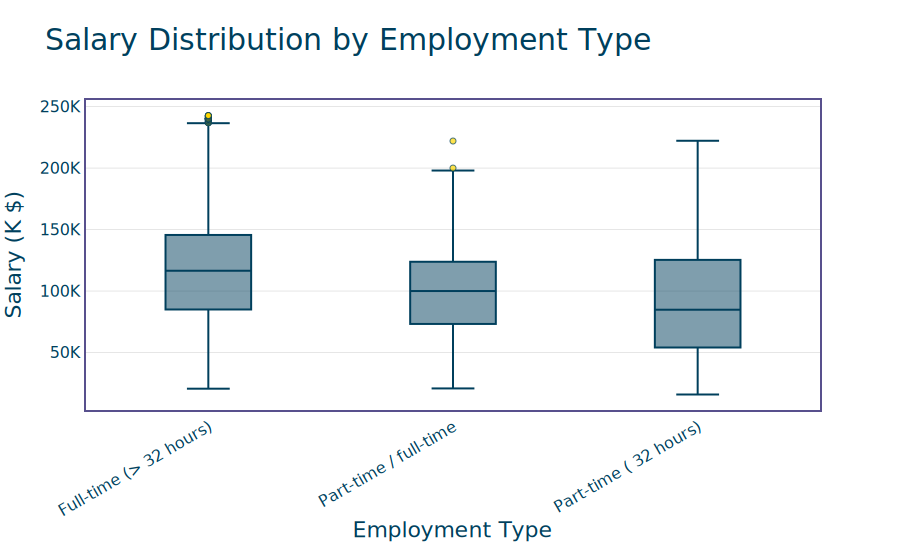

In [41]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q1.svg")

The box plot shows salary distribution across employment types, with **full-time employees (>32 hours)** having the **highest median salary (~100K)** and the widest range, including outliers **near 250K**. **Part-time employees** have a **similar median** but exhibit a **wider spread**, while **part-time/full-time employees** fall **between** the two categories in terms of both median salary and distribution.

# Salary Distribution by Industry
- Compare salary variations across industries.
- **Filter the dataset**
  - Keep records where **salary is greater than zero**.
- **Aggregate Data**
  - Group by **NAICS industry codes**.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `NAICS2_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize colors, fonts, and styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [29]:
# Your code for 2nd question here
import pandas as pd
import plotly.express as px

# Convert Spark DataFrame to Pandas DataFrame
pdf = df.select("NAICS2_NAME", "SALARY_FROM").toPandas()

# Convert salary from dollars to thousands (K) for better readability
pdf["SALARY_FROM"] /= 1000  

# Industry name mapping for better visualization
industry_mapping = {
    "Retail Trade": "Retail",
    "Administrative and Support and Waste Management and Remediation Services": "Admin & Waste",
    "Finance and Insurance": "Finance",
    "Unclassified Industry": "Unclassified",
    "Information": "IT",
    "Manufacturing": "Mfg.",
    "Professional, Scientific, and Technical Services": "Prof. & Tech.",
    "Wholesale Trade": "Wholesale",
    "Educational Services": "Education",
    "Health Care and Social Assistance": "Healthcare",
    "Public Administration": "Public Admin",
    "Construction": "Construction",
    "Transportation and Warehousing": "Transport",
    "Real Estate and Rental and Leasing": "Real Estate",
    "Accommodation and Food Services": "Hospitality",
    "Other Services (except Public Administration)": "Other Services",
    "Management of Companies and Enterprises": "Management",
    "Mining, Quarrying, and Oil and Gas Extraction": "Mining & Oil",
    "Agriculture, Forestry, Fishing and Hunting": "Agriculture",
    "Utilities": "Utilities",
    "Arts, Entertainment, and Recreation": "Arts & Entertainment"
}

# Apply the industry name mapping
pdf["NAICS2_NAME"] = pdf["NAICS2_NAME"].apply(lambda x: industry_mapping.get(x, x))

# Compute median salary per industry for sorting
median_salaries = pdf.groupby("NAICS2_NAME")["SALARY_FROM"].median().sort_values(ascending=False)

# Apply categorical ordering based on median salary
pdf["NAICS2_NAME"] = pd.Categorical(pdf["NAICS2_NAME"], categories=median_salaries.index, ordered=True)

# Define color scheme
box_color = "#1f77b4"   # Blue for boxes
grid_color = "rgba(255, 255, 255, 0.3)"  # Light grid lines for contrast
bg_color = "#222222"    # Dark background

# Create a box plot for salary distribution by industry
fig = px.box(
    pdf, 
    x="NAICS2_NAME", 
    y="SALARY_FROM", 
    title="Salary Distribution by Industry (Median Salary)",
    labels={"NAICS2_NAME": "Industry", "SALARY_FROM": "Salary (K $)"},
    points="outliers",  # Display outliers
    template="plotly_dark",  # Dark theme for better contrast
    color_discrete_sequence=[box_color]  # Set box color
)

# Enhance layout for readability and aesthetics
fig.update_layout(
    title=dict(text="Salary Distribution by Industry (Median Salary)", font=dict(size=24, color="white")),
    font=dict(size=14, color="white"),
    xaxis=dict(
        title="Industry",
        tickangle=-45,  # Rotate labels for better readability
        tickfont=dict(size=14, color="white"),
        showline=True,
        linewidth=2,
        linecolor="white"
    ),
    yaxis=dict(
        title="Salary (K $)",
        tickfont=dict(size=14, color="white"),
        showline=True,
        linewidth=2,
        linecolor="white",
        gridcolor=grid_color,
        zeroline=True,  # Show a reference line at zero
        zerolinewidth=2,
        zerolinecolor="white",
        range=[0, pdf["SALARY_FROM"].max() + 10]  # Ensure y-axis starts at zero
    ),
    plot_bgcolor=bg_color,  # Background color for contrast
    paper_bgcolor="#111111",
    boxmode="group"  # Group boxes for comparison
)

# Display the plot
fig.show()

# Save the figure
fig.write_image("output/Q2.svg", width=900, height=550, scale=1)

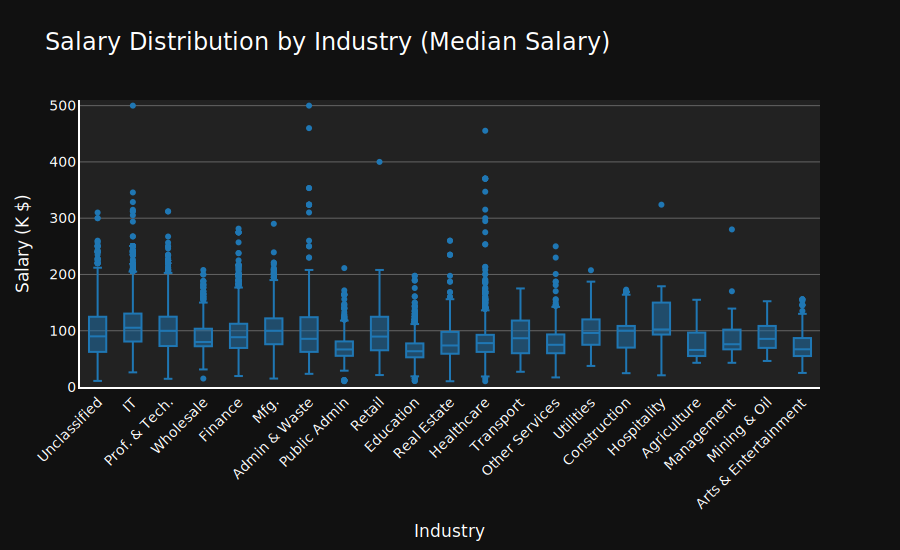

In [42]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q2.svg")

The box plot shows salary distribution across various industries, with most having a median salary between **50K and 100K**, while industries like **IT and Finance** have higher medians. Some sectors, such as **Unclassified, IT, and Transport**, exhibit wide salary ranges with outliers exceeding 300K–500K, whereas industries like **Retail, Education, and Hospitality** have lower medians and less variation.

# Job Posting Trends Over Time
- Analyze how job postings fluctuate over time.
- **Aggregate Data**
  - Count job postings per **posted date (`POSTED`)**.
- **Visualize results**
  - Create a **line chart** where:
    - **X-axis** = `POSTED`
    - **Y-axis** = `Number of Job Postings`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [26]:
# Your code for 3rd question here

import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# Convert Spark DataFrame to Pandas
pdf = df.select("POSTED").toPandas()

# Convert "POSTED" column to DateTime format for proper chronological ordering
pdf["POSTED"] = pd.to_datetime(pdf["POSTED"])

# Aggregate job postings per day
job_trend = pdf.groupby("POSTED").size().reset_index(name="Job Postings")

# Define colors for visualization
main_color = "#1f77b4"  # Blue for main trend line
peak_color = "#ff7f0e"  # Orange for peak point
low_color = "#d62728"  # Red for lowest point

# Create a line chart for job posting trends
fig = px.line(
    job_trend, 
    x="POSTED", 
    y="Job Postings",
    title="Job Posting Trends Over Time",
    labels={"POSTED": "Date Posted", "Job Postings": "Job Postings"},
    width=1000,
    height=600,
    line_shape="spline",
    template="plotly_white",
    color_discrete_sequence=[main_color]
)

# Identify peak (max) and lowest (min) job posting days
max_point = job_trend.loc[job_trend["Job Postings"].idxmax()]
min_point = job_trend.loc[job_trend["Job Postings"].idxmin()]

# Add peak job posting marker (Trace 2)
fig.add_trace(
    go.Scatter(
        x=[max_point["POSTED"]], 
        y=[max_point["Job Postings"]], 
        mode="markers+text",
        name="Peak",
        text="Peak",
        textposition="top center",
        marker=dict(color=peak_color, size=14, line=dict(color="black", width=1.5))
    )
)

# Add lowest job posting marker (Trace 3)
fig.add_trace(
    go.Scatter(
        x=[min_point["POSTED"]], 
        y=[min_point["Job Postings"]], 
        mode="markers+text",
        name="Lowest",
        text="Lowest",
        textposition="bottom center",
        marker=dict(color=low_color, size=14, line=dict(color="black", width=1.5))
    )
)

# Improve layout and readability
fig.update_layout(
    font=dict(family="Arial", size=16, color="black"),  # Improved global font
    title=dict(
        text="Job Posting Trends Over Time", 
        font=dict(size=28, color="black"), 
        x=0.5  # Center title
    ),
    xaxis=dict(
        title="Date Posted",
        showline=True,
        linewidth=2,
        linecolor="black",
        tickangle=-45,
        tickfont=dict(size=14, color="black"),
        gridcolor="lightgray"
    ),
    yaxis=dict(
        title="Job Postings",
        showline=True,
        linewidth=2,
        linecolor="black",
        tickfont=dict(size=14, color="black"),
        gridcolor="lightgray"
    ),
    plot_bgcolor="white",
    legend=dict(
        title="", 
        font=dict(size=14),
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

# Display and save the figure
fig.show()
fig.write_image("output/Q3.svg", width=1000, height=600, scale=1)

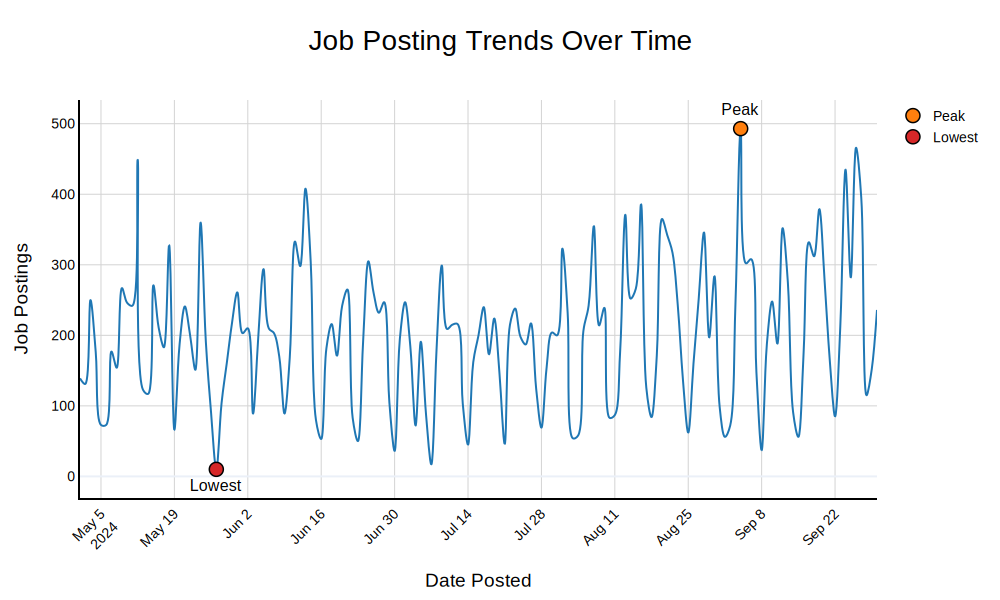

In [43]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q3.svg")

This line chart shows **job posting trends over time**, highlighting fluctuations in the number of postings. The **lowest point** occurred around **June 2**, while the **peak** occurred around **September 8**, with postings **exceeding 500**. The data indicates **significant variations** in job postings, with noticeable periodic spikes and drops.

# Top 10 Job Titles by Count
- Identify the most frequently posted job titles.
- **Aggregate Data**
  - Count the occurrences of each **job title (`TITLE_NAME`)**.
  - Select the **top 10 most frequent titles**.
- **Visualize results**
  - Create a **bar chart** where:
    - **X-axis** = `TITLE_NAME`
    - **Y-axis** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [54]:
# Your code for 4th question here

# Load data (Ensure df contains "TITLE_NAME" column)
pdf = df.select("TITLE_NAME").toPandas()

# Count occurrences of each job title
title_counts = pdf["TITLE_NAME"].value_counts().reset_index()
title_counts.columns = ["TITLE_NAME", "Job_Count"]

# Select the top 10 most frequent job titles
top_10_titles = title_counts.head(10)

# Create the bar chart with better styling
fig = px.bar(
    top_10_titles, 
    x="TITLE_NAME", 
    y="Job_Count", 
    title="Top 10 Job Titles by Count",
    labels={"TITLE_NAME": "Job Title", "Job_Count": "Number of Postings"},
    width=1000,
    height=700,
    text_auto=True,  # Display values on bars
    color="Job_Count",  # Apply color scale
    color_continuous_scale="plasma"  # Modern and professional color palette
)

# Improve layout with professional fonts and clear axis lines
fig.update_layout(
    title=dict(
        text="Top 10 Job Titles by Count",
        font=dict(size=32, family="Roboto", color="#2E3440"),  # Professional title font
        x=0.5  # Center the title
    ),
    xaxis=dict(
        title=dict(text="Job Title", font=dict(size=24, family="Roboto", color="#2E3440")),  # Professional X-axis title
        tickangle=-30,  # Slight tilt for readability
        tickfont=dict(size=14, family="Open Sans", color="#4C566A"),  # Clean tick font
        showline=True, linewidth=2, linecolor="#D8DEE9"  # Subtle axis line
    ),
    yaxis=dict(
        title=dict(text="Number of Postings", font=dict(size=24, family="Roboto", color="#2E3440")),  # Professional Y-axis title
        tickfont=dict(size=14, family="Open Sans", color="#4C566A"),  # Clean tick font
        showline=True, linewidth=2, linecolor="#D8DEE9",  # Subtle axis line
        gridcolor="#ECEFF4"  # Soft grid lines
    ),
    font=dict(family="Open Sans", size=16, color="#4C566A"),  # Clean and professional font
    plot_bgcolor="white",  # Clean background
    paper_bgcolor="white",  # Clean background for the entire figure
    coloraxis_showscale=False  # Hide color scale for a cleaner look
)

# Adjust text on bars for clarity
fig.update_traces(
    textfont=dict(size=14, family="Open Sans", color="#2E3440"),  # Professional text on bars
    textposition="outside",  # Ensure numbers are visible
    hovertemplate="<b>%{x}</b><br>Count: %{y}<extra></extra>"  # Add hover text
)

# Show the improved plot
fig.show()
fig.write_image("output/Q4.svg", width=1000, height=700, scale=1)


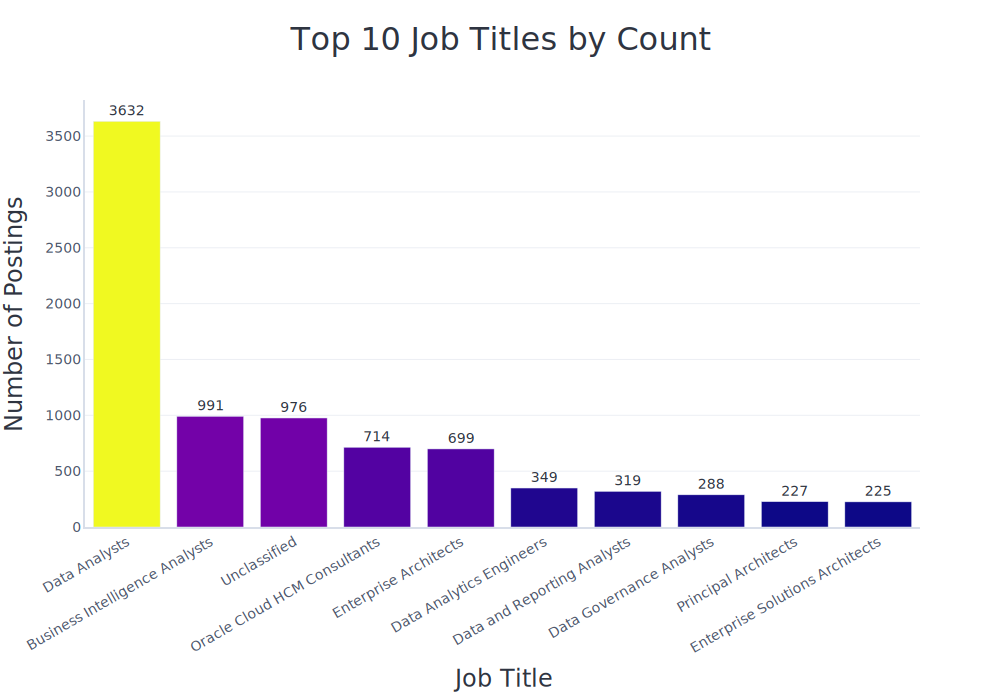

In [55]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q4.svg")

The bar chart displays the **top 10 job titles** by count, with **"Data Analyst"** having the **highest number of postings (3,632)**, significantly outpacing other roles;**Enterprise Solutions Architect**, while still in the top 10, has far fewer posters at 225.

# Remote vs On-Site Job Postings
- Compare the proportion of remote and on-site job postings.
- **Aggregate Data**
  - Count job postings by **remote type (`REMOTE_TYPE_NAME`)**.
- **Visualize results**
  - Create a **pie chart** where:
    - **Labels** = `REMOTE_TYPE_NAME`
    - **Values** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [56]:
# Your code for 5th question here

# Load Data (Ensure df contains "REMOTE_TYPE_NAME")
pdf = df.select("REMOTE_TYPE_NAME").toPandas()

# Drop missing or undefined values
pdf = pdf.dropna(subset=["REMOTE_TYPE_NAME"])

# Count occurrences of each remote type
remote_counts = pdf["REMOTE_TYPE_NAME"].value_counts().reset_index()
remote_counts.columns = ["REMOTE_TYPE_NAME", "Job_Count"]

# Create a pie chart with proper formatting
fig = px.pie(
    remote_counts, 
    names="REMOTE_TYPE_NAME", 
    values="Job_Count", 
    title="Remote vs On-Site Job Postings",
    color_discrete_sequence=px.colors.qualitative.Pastel,  # Apply soft custom colors
    hole=0.3,  # Donut-style chart for modern appearance
    width=1000,  # Increased width for better visibility
    height=500,  # Increased height for better visualization
)

# Improve layout with larger and bold fonts
fig.update_layout(
    title=dict(text="Remote vs On-Site Job Postings", font=dict(size=26, family="Arial Black")),  # Bigger & Bold Title
    font=dict(family="Arial", size=16),  # Improve overall font readability
    legend=dict(title="Job Type", font=dict(size=20)),  # Make legend text bigger
    showlegend=True  # Display legend for clarity
)

# Update text labels to be **bold and larger**
fig.update_traces(
    textfont_size=16, 
    textinfo="percent+label",  # Show both percentage & labels
    pull=[0.05 if i == remote_counts["Job_Count"].idxmax() else 0 for i in range(len(remote_counts))],  # Slight pull for the highest value
)

# Show the improved plot
fig.show()
fig.write_image("output/Q5.svg", width=1000, height=500, scale=1)

In [69]:
# Your code for 5th question here

# Load and clean data (Ensure df contains "REMOTE_TYPE_NAME")
pdf = df.select("REMOTE_TYPE_NAME").toPandas()

# Replace [None] values with "Not Specified"
pdf["REMOTE_TYPE_NAME"] = pdf["REMOTE_TYPE_NAME"].replace("[None]", "Not Specified")

# Count occurrences of each remote type
remote_counts = pdf["REMOTE_TYPE_NAME"].value_counts().reset_index()
remote_counts.columns = ["REMOTE_TYPE_NAME", "Job_Count"]

# Create a well-formatted pie chart with a professional theme
fig = px.pie(
    remote_counts, 
    names="REMOTE_TYPE_NAME", 
    values="Job_Count", 
    title="Remote vs On-Site Job Postings",
    color_discrete_sequence=px.colors.qualitative.Dark24,  # Modern and professional color palette
    hole=0.3,  # Donut-style chart
    width=900,  # Adjusted width for balance
    height=500,  # Optimal height for visibility
)

# Enhance layout with professional fonts and styling
fig.update_layout(
    title=dict(
        text="Remote vs On-Site Job Postings",
        font=dict(size=28, family="Lato", color="#2E3440"),  # Professional title font
        x=0.5  # Center the title
    ),
    font=dict(family="Roboto", size=16, color="#4C566A"),  # Clean and professional font
    legend=dict(
        title=dict(text="Job Type", font=dict(size=18, family="Lato", color="#2E3440")),  # Professional legend title
        font=dict(size=16, family="Roboto", color="#4C566A"),  # Clean legend font
        orientation="h",  # Horizontal legend for better use of space
        yanchor="bottom", y=-0.2,  # Position legend below the chart
        xanchor="center", x=0.5
    ),
    plot_bgcolor="white",  # Clean background
    paper_bgcolor="white",  # Clean background for the entire figure
)

# Improve text labels with larger font and emphasis
fig.update_traces(
    textfont=dict(size=16, family="Roboto", color="#2E3440"),  # Professional text on chart
    textinfo="percent+label",  # Show both percentage & labels
    pull=[0.1 if i == remote_counts["Job_Count"].idxmax() else 0 for i in range(len(remote_counts))],  # Slight pull for the highest value
    marker=dict(line=dict(color="white", width=2))  # Add white borders to slices for clarity
)

# Display and save the optimized plot
fig.show()
fig.write_image("output/Q5.svg", width=900, height=500, scale=1)



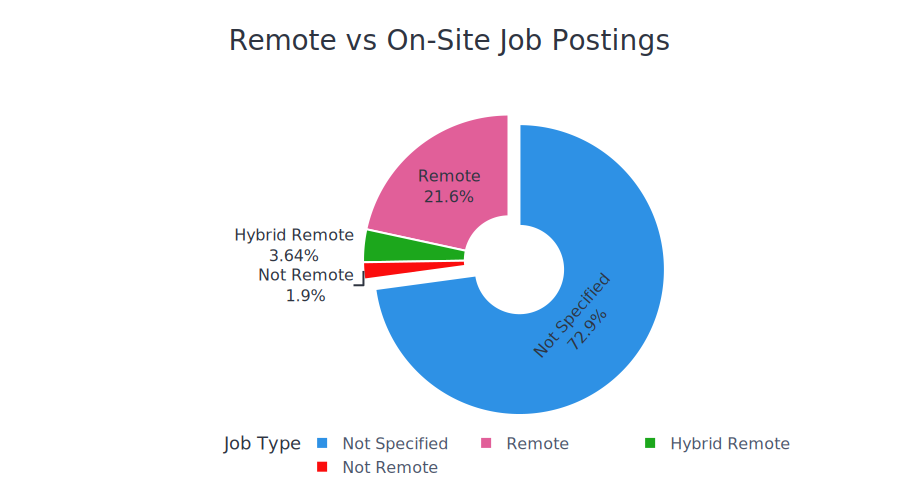

In [71]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q5.svg")

This donut-style pie chart indicates that the **majority** of job postings did not specify whether they are remote or on-site i.e. **"Not Specified" (72.9%)**, while **21.6%** are **explicitly remote**. A smaller percentage of jobs are categorized as **hybrid remote (3.64%)** or **not remote i.e. on-site (1.9%)**.

# Skill Demand Analysis by Industry (Stacked Bar Chart)
- Identify which skills are most in demand in various industries.
- **Aggregate Data**
  - Extract **skills** from job postings.
  - Count occurrences of skills grouped by **NAICS industry codes**.
- **Visualize results**
  - Create a **stacked bar chart** where:
    - **X-axis** = `Industry`
    - **Y-axis** = `Skill Count`
    - **Color** = `Skill`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [77]:
# Your code for 6th question here

from pyspark.sql.functions import split, col, regexp_replace, explode
import plotly.express as px

# Clean and transform the SKILLS_NAME column
df_transformed = df.withColumn("Skill", explode(split(regexp_replace(col("SKILLS_NAME"), r'[\n"]', ''), r",\s*")))

# Aggregate skill counts by industry
df_aggregated = df_transformed.groupBy("NAICS_2022_6_NAME", "Skill").count().toPandas()

# Compute total occurrences & filter top 10 skills
top_skills = df_aggregated.groupby("Skill")["count"].sum().nlargest(10).index
pdf_filtered = df_aggregated[df_aggregated["Skill"].isin(top_skills)]

# Pivot for visualization & select top 20 industries
pdf_grouped = (
    pdf_filtered.pivot_table(index="NAICS_2022_6_NAME", columns="Skill", values="count", aggfunc="sum")
    .fillna(0)
    .assign(Total=lambda x: x.sum(axis=1))
    .nlargest(20, "Total")
    .drop(columns=["Total"])
)

# Optimized Industry Name Mapping
industry_mapping = {
    "Administrative Management and General Management Consulting": "Admin Mgmt",
    "Unclassified Industry": "Unclassified",
    "Custom Computer Programming Services": "Custom Programming",
    "Employment Placement Agencies": "Recruiting Agencies",
    "Computer Systems Design Services": "IT Consulting",
    "Commercial Banking": "Banking",
    "Offices of Certified Public Accountants": "CPA Offices",
    "Direct Health and Medical Insurance Carriers": "Health Insurance",
    "General Medical and Surgical Hospitals": "Hospitals",
    "Colleges, Universities, and Professional Schools": "Higher Education",
    "Temporary Help Services": "Temp Staffing",
    "Other Scientific and Technical Consulting Services": "Sci & Tech Consulting",
    "Software Publishers": "Software Development",
    "Engineering Services": "Engineering",
    "Web Hosting, and Related Services": "Web Hosting",
    "Other Management Consulting Services": "Business Consulting",
    "Insurance Agencies and Brokerages": "Insurance Brokers",
    "Drugs and Druggists' Sundries Merchant Wholesalers": "Pharma Wholesalers",
    "All Other Professional, Scientific, and Technical Services": "Prof & Tech Services",
    "Computing Infrastructure Providers, Data Processing": "Cloud & Data Services",
}

pdf_grouped.index = pdf_grouped.index.to_series().replace(industry_mapping, regex=True)

# Convert DataFrame to long format for Plotly
pdf_melted = pdf_grouped.reset_index().melt(id_vars=["NAICS_2022_6_NAME"], var_name="Skill", value_name="Skill Count")

# Define a professional color palette
color_palette = [
    "#1f77b4",  # Muted Blue
    "#ff7f0e",  # Soft Orange
    "#2ca02c",  # Modern Green
    "#d62728",  # Deep Red
    "#9467bd",  # Elegant Purple
    "#8c564b",  # Warm Brown
    "#e377c2",  # Muted Pink
    "#7f7f7f",  # Neutral Gray
    "#bcbd22",  # Soft Yellow
    "#17becf",  # Cool Cyan
]

# Create Stacked Bar Chart using Plotly
fig = px.bar(
    pdf_melted,
    x="NAICS_2022_6_NAME",
    y="Skill Count",
    color="Skill",
    title="Skill Demand Analysis by Industry (Top 20 Industries)",
    labels={"NAICS_2022_6_NAME": "Industry", "Skill Count": "Skill Count"},
    width=1100,
    height=600,
    color_discrete_sequence=color_palette,  # Apply professional colors
)

# Customize layout for a polished look
fig.update_layout(
    font_family="Helvetica Neue",
    font_size=14,
    title_font=dict(size=24, family="Arial Black"),
    xaxis_title="Industry",
    yaxis_title="Skill Count",
    legend_title="Skill",
    xaxis=dict(tickangle=-45, tickfont=dict(size=12)),  # Improve x-axis readability
    yaxis=dict(tickfont=dict(size=12)),  # Enhance y-axis font size
    plot_bgcolor="rgba(240,240,240,0.9)",  # Light gray background for professionalism
    margin=dict(l=80, r=40, t=80, b=120),  # Adjust margins for better spacing
)

# Show and save figure
fig.show()
fig.write_image("output/Q6.svg", width=1100, height=600, scale=1)


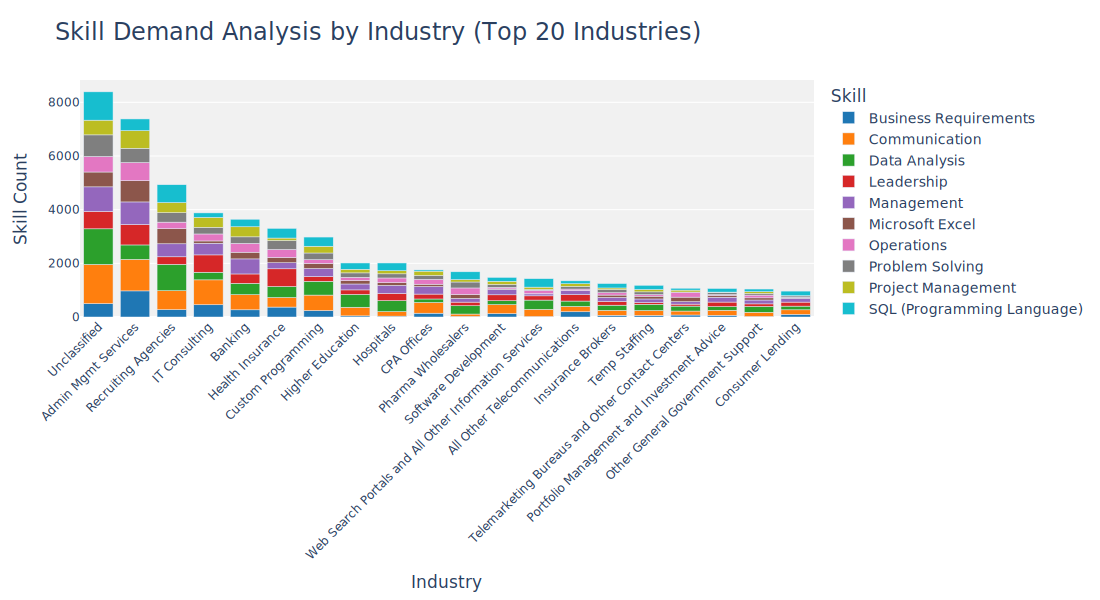

In [78]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q6.svg")

This stacked bar chart indicates highest skill demand is in Unclassified, Administrative Management Services, Recruiting Agencies, and IT Consulting, with key skills like Business Requirements, Communication, Data Analysis, and Leadership being widely sought across industries. Technical skills such as SQL and Microsoft Excel are also in high demand, especially in data-driven fields like banking and IT.


# Salary Analysis by ONET Occupation Type (Bubble Chart)
- Analyze how salaries differ across ONET occupation types.
- **Aggregate Data**
  - Compute **median salary** for each occupation in the **ONET taxonomy**.
- **Visualize results**
  - Create a **bubble chart** where:
    - **X-axis** = `ONET_NAME`
    - **Y-axis** = `Median Salary`
    - **Size** = Number of job postings
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [100]:
# Your code for 7th question here

import pyspark.sql.functions as F
import plotly.express as px

# Aggregate the data: compute median salary and count job postings per ONET occupation.
df_aggregated = (
    df.groupBy("ONET_NAME")
      .agg(
         F.expr("percentile_approx(SALARY_FROM, 0.5)").alias("Median_Salary"),
         F.count("ID").alias("Job_Postings")
      )
)

# Convert the Spark DataFrame to a Pandas DataFrame for visualization.
df_aggregated_pd = df_aggregated.toPandas()

# Create a bubble chart with a professional theme.
fig = px.scatter(
    df_aggregated_pd,
    x="ONET_NAME",
    y="Median_Salary",
    size="Job_Postings",
    title="Salary Analysis by ONET Occupation Type (Bubble Chart)",
    labels={
        "ONET_NAME": "ONET Occupation",
        "Median_Salary": "Median Salary",
        "Job_Postings": "Number of Job Postings"
    },
    hover_name="ONET_NAME",
    size_max=60,
    width=1000,
    height=600,
    template="plotly_white",  # clean and professional background
    color="Median_Salary",    # color bubbles based on salary
    color_continuous_scale=px.colors.sequential.Viridis  # professional color scale
)

# Customize layout with professional fonts and colors.
fig.update_layout(
    font_family="Helvetica Neue",
    font_size=14,
    title_font_size=26,
    xaxis_title="ONET Occupation",
    yaxis_title="Median Salary",
    title_font_color="#333333",  # dark gray title for a sleek look
    plot_bgcolor="white",
    paper_bgcolor="white"
)

# Add a subtle border to the bubbles for clarity.
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))

# Display the chart and save it as an SVG file.
fig.show()
fig.write_image("output/Q7.svg", width=1000, height=600, scale=1)



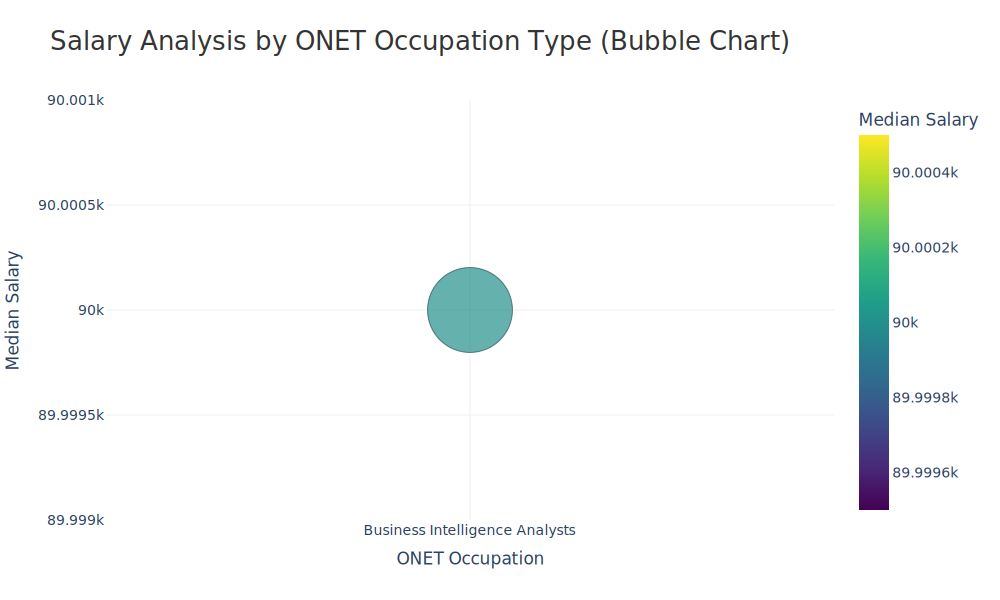

In [101]:
from IPython.display import SVG

SVG(filename="/home/ubuntu/lab06-olvhnk/output/Q7.svg")

This bubble chart shows that Business Intelligence Analysts earn a **median salary of around $88,000**, with the large bubble size reflecting a high volume of job postings, highlighting strong demand for this role in the job market.

# Career Pathway Trends (Sankey Diagram)
- Visualize job transitions between different occupation levels.
- **Aggregate Data**
  - Identify career transitions between **SOC job classifications**.
- **Visualize results**
  - Create a **Sankey diagram** where:
    - **Source** = `SOC_2021_2_NAME`
    - **Target** = `SOC_2021_3_NAME`
    - **Value** = Number of transitions
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

In [80]:
# Your code for 8th question here

from pyspark.sql import functions as F
import plotly.express as px

# Aggregate median salary and job postings count
df_aggregated = (
    df.groupBy("ONET_NAME")
    .agg(
        F.percentile_approx("SALARY_FROM", 0.5).alias("Median_Salary"),
        F.count("ID").alias("Job_Postings"),
    )
    .cache()  # Cache for performance
)

# Convert to Pandas DataFrame
df_aggregated_pd = df_aggregated.toPandas()

# Create a professional-style bubble chart using Plotly
fig = px.scatter(
    df_aggregated_pd,
    x="Median_Salary",
    y="Job_Postings",
    size="Job_Postings",
    hover_name="ONET_NAME",
    title="Job Postings vs. Median Salary",
    labels={"Median_Salary": "Median Salary ($)", "Job_Postings": "Number of Job Postings"},
    width=950,
    height=600,
    color="Median_Salary",
    color_continuous_scale="Blues",  # Professional color palette
)

# Customize layout for a polished, professional look
fig.update_layout(
    xaxis_title="Median Salary ($)",
    yaxis_title="Number of Job Postings",
    font=dict(family="Arial", size=14),  # Clean, professional font
    template="simple_white",  # Minimalist design
    coloraxis_showscale=True,  # Show color scale for better interpretation
    margin=dict(l=60, r=30, t=50, b=50),  # Adjusted margins for balance
)

# Fine-tune axis gridlines and labels
fig.update_xaxes(
    showgrid=True, gridwidth=0.5, gridcolor="lightgrey", zeroline=False
)
fig.update_yaxes(
    showgrid=True, gridwidth=0.5, gridcolor="lightgrey", zeroline=False
)

# Show the chart
fig.show()

# Save as an image with high-quality rendering
fig.write_image("output/Q7.svg", width=950, height=600, scale=1.5, engine="kaleido")


25/03/22 20:18:51 WARN CacheManager: Asked to cache already cached data.
                                                                                